In [1]:
import alias
import alias.injection as inj

import numpy as np
import matplotlib.pyplot as plt

import scipy

import tqdm.autonotebook as tqdm

/mnt_home/jhand/alias/alias/injection.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
# Load files into dataset

with open('../data/sample_star_urls_rev2', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra_rev2/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/mnt_home/jhand/alias/alias/__init__.py:58: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


In [3]:
median = np.nanmedian(ds.flux, axis=1)
residuals = ds.flux - median[:,None]

(0.5, 1.5)

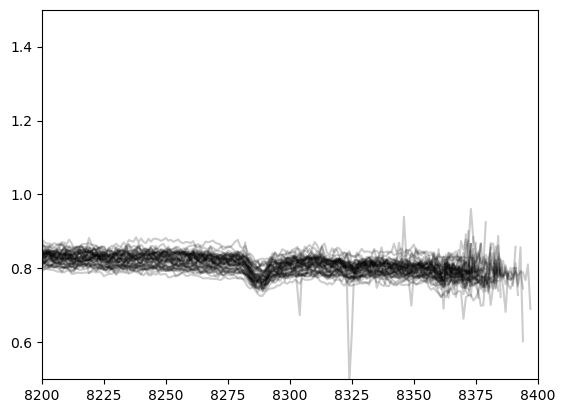

In [4]:
# Manually inspecting small regions of the spectrum to identify continuum pixels.

_ = plt.plot(ds.flux.T[:,:50], color='black', alpha=0.2)

n = 41
plt.xlim(200*n, 200*(n+1))
plt.ylim(0.5, 1.5)

Through visual inspection of the spectra, the continuum pixels were selectet to be at indices:

- CCD 1: 250, 450, 760, 860, 1050, 1300, 1500, 1700, 1885, 2157, 2300, 2460, 2690, 2900, 3100, and 3270
- CCD 2: 3555, 3675, 3900, 4150, 4260, 4500, 4700, 4850, 5030, 5360, 5460, 5675, 5865, and 6100
- CCD 3: 6365, 6490, 6730, 6875, 7050, 7370, 7500, 7700, 7950, 8075, and 8250

and the gaps between the CCDs were determined to be at indices 3400 and 6250.

In [5]:
continuum_pix = [
    [ 250, 450, 760, 1050, 1300, 1700, 1885, 2300, 2460, 2690, 2900, 3270 ],
    [ 3555, 3900, 4150, 4260, 4700, 4850, 5030, 5460, 5675, 5865, 6100 ],
    [ 6365, 6490, 6730, 6875, 7050, 7370, 7500, 7700, 7950, 8075, 8250 ]
]

def continuum_norm(flux, ivar):
    
    p = [ np.polyfit(cont_p, flux[cont_p], 6) for cont_p in continuum_pix]
    cont = np.array([ np.polyval(c, range(len(ds.wave))) for c in p])
    
    flux_norm = np.copy(flux)
    ivar_norm = np.copy(ivar)
    
    flux_norm[:3400] /= cont[0][:3400]
    flux_norm[3400:6250] /= cont[1][3400:6250]
    flux_norm[6250:] /= cont[2][6250:]

    ivar_norm[:3400] *= cont[0][:3400]**2
    ivar_norm[3400:6250] *= cont[1][3400:6250]**2
    ivar_norm[6250:] *= cont[2][6250:]**2

    return flux_norm, ivar_norm

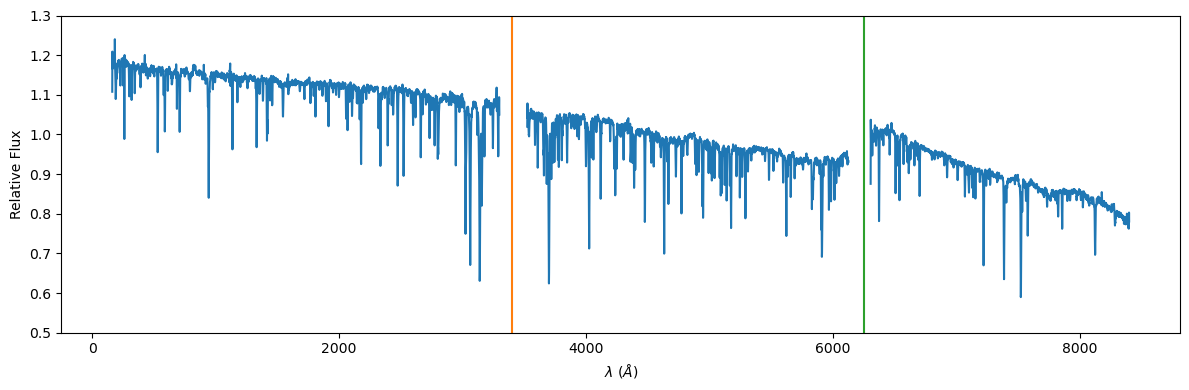

In [13]:
plt.figure(figsize=(12,4))

plt.plot(ds.flux[101])
plt.plot([3400]*2, (0,2))
plt.plot([6250]*2, (0,2))
plt.ylim(0.5, 1.3)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')


plt.xlabel(r'$\lambda$ ($\AA$)')
_ = plt.ylabel(r'Relative Flux')

plt.tight_layout()

In [7]:
data = np.array([ continuum_norm(ds.flux[n], ds.ivar[n]) for n in range(len(ds.flux))])

flux_norm = data[:,0,:]
ivar_norm = data[:,1,:]

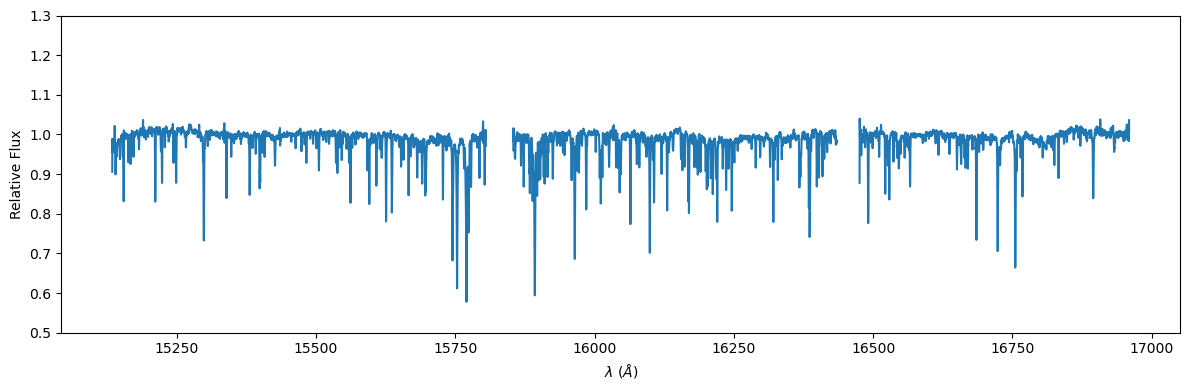

In [14]:
plt.figure(figsize=(12,4))

plt.plot(ds.wave, flux_norm[101])
plt.ylim(0.5, 1.3)


plt.xlabel(r'$\lambda$ ($\AA$)')
_ = plt.ylabel(r'Relative Flux')

plt.tight_layout()

plt.savefig('continuum_normalized.png', dpi=150)